In [4]:
"""
eSTRs motifs drive expression in either direction
We test the the direction of effect of eSTRs motifs and plot +/- log10(pvalue)
                    with (-) if beta<0 most of the time   
Binomial test
        H0: motif has pos. effect 50% of the time' 
"""

# Libraries
from collections import defaultdict
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as ss
import seaborn as sns

#functions
def getfisher(R, TISSUES):
    O=defaultdict(list)
    Mapdata = {}
    for tis in TISSUES:

        field= 'eSTR.'+SHORTEN[tis]

        # Focus on estrs and motifs
        data = R[["gene","chrom", "str.start","motif",field]]#,"best.score","best.tissue","INTRON"]]
        data_e = data.loc[data[field]>0]
        #
        #frequent_motifs estrs
        Motifs = list(set(list(data_e['motif'])))
        Mo_counts=[list(data['motif']).count(x) for x in Motifs]
        Estr = data_e.shape[0]
        Str = data.shape[0]
        All = []
        # Fisher test for each motif
        for M in Motifs:
            data_eM = data_e.loc[data_e['motif']==M]
            data_M = data.loc[data['motif']==M]
            Mestrs = data_eM.shape[0]
            Mstrs = data_M.shape[0]
            CTT = [[Mestrs, Estr - Mestrs] , [Mstrs-Mestrs , Str-Estr -(Mstrs - Mestrs)]] #contengency
            oddsratio, pv = ss.fisher_exact([CTT[0], CTT[1]])                             #Fisher
            #print ("P (", M, ")    ~~   ",pv*100,"%     with    OR=", oddsratio)
        #
            All.append([M,list(data_e['motif']).count(M),-np.log10(pv),oddsratio])
            O[M].append(oddsratio)
        #
        Mapdata[tis]=All
    # Selecting motifs present in all tissues
    Mset = []
    for o in O.keys():      # O has all the motifs and occurence in tissues
        if len(O[o])>=len(TISSUES):
            Mset.append(o)
    print(len(Mset))
    #heatmap matix
    pdata = np.zeros((len(TISSUES), len(Mset)))
    for i in range(len(TISSUES)):
        T = TISSUES[i]
        for j in range(len(Mset)):
            m=Mset[j]
            val = [s[3] for s in  Mapdata[T] if s[0]==m ]
            if val==[]:
                pdata[i][j] =0
            else:
                pdata[i][j] =val[0]
    return Mset, O,Mapdata, pdata

# Output path
OUTPATH = "../pdfs"
PREFIX = "SupllFigure2" # Keep as a variable in case we move things around!

#variables

SHORTEN = {
    "Artery-Aorta":"Artery.A"     ,
    "Artery-Tibial": "Artery.T",
    "Adipose-Subcutaneous": "Adipose.S",    
    "Adipose-Visceral":"Adipose.V",
    "Brain-Caudate":"Caudate"   , 
    "Brain-Cerebellum":"Cerebellum",
    "Cells-Transformedfibroblasts": "Fibroblast",
    "Esophagus-Mucosa": "Mucosa",
    "Esophagus-Muscularis":"Muscularis",
    "Heart-LeftVentricle":"Heart",
    "Lung": "Lung",
    "Muscle-Skeletal": "Muscle",
    "Nerve-Tibial":"Nerve",
    "Skin-NotSunExposed": "SkinUnexposed",
    "Skin-SunExposed":"SkinLeg",
    "Thyroid":"Thyroid",
    "WholeBlood": "Blood"
}
TISSUES = sorted([item for item in list(SHORTEN.keys()) if item != "permuted"])
regr='/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/LR_SummaryTest_Table.tsv'
feat='/storage/szfeupe/Runs/GTEx_estr/FEATURES/Allgencodefeatures_table'
motif='/storage/resources/dbase/human/hg19/hg19.hipstr_reference_withmotif.bed'
strand= '/storage/resources/dbase/human/hg19/hg19.hipstr_reference_withmotif_stranded.bed'
Cause = '/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/'

In [2]:
#open files
#regression summary
data = pd.read_csv(regr, sep='\t')  ; X = data[["gene","chrom","str.start","E.tissues",'motif']]
betas = ['beta.'+SHORTEN[T] for T in TISSUES]

#Motifs list                        Can restrict to estrs only
estrs = data.loc[data['E.tissues']>0]            #
motifs = list(set(list(estrs['motif'])))

#Counts motifs by tissues
Counts={}
Counts['Tissues']=TISSUES
ODDMOTIF=[]
for m in motifs:
    L=[]
    nul=0
    for T in TISSUES:
        E =data.loc[data['eSTR.'+SHORTEN[T]]>0]
        Npos = E.loc[E['beta.'+SHORTEN[T]]>0].copy()      ##beta>0  pos effect
        Nneg = E.loc[E['beta.'+SHORTEN[T]]<0].copy()      ###beta<0
        emotif_no = list(Npos['motif']).count(m)
        emotif_nn = list(Nneg['motif']).count(m)
        #Function to get effect size  ie effect of sample on motif (corr motif enrichment at eSTR vs any STR)
        pval = ss.binom_test(emotif_no, n=emotif_no+emotif_nn, p=0.5)   #[success is beta>0 at least 50% of the time]
        if emotif_nn + emotif_no ==0:
            Pv = 0
            nul = nul+1
        elif emotif_no/(emotif_no + emotif_nn) >0.5:
            Pv = -np.log10(pval)     #make + when more beta>0
        else:
            Pv = +np.log10(pval)     #keep - when more beta<0
            
        L.append(Pv)
    if nul==len(TISSUES):
        ODDMOTIF.append(m+'*')
    elif nul!=len(TISSUES) and sum(L)==0:
        ODDMOTIF.append(m+'-')
    else:
        Counts[m]=L

print(len(ODDMOTIF),' motifs without counts\n', ODDMOTIF)
df = pd.DataFrame.from_dict(Counts)
df = df.sort_values('Tissues')
df.index = list(df['Tissues']) 
del df['Tissues']
df.loc['Total']= df.sum()
sorted_df = df.sort_values(df.last_valid_index(), axis=1)
#sorted_df

111  motifs without counts
 ['ACTGCC-', 'ACAGGG-', 'AATAC-', 'ACGTC-', 'ATATC-', 'AACG-', 'ACGGAG-', 'AATTC-', 'AAATAG-', 'ATGCCC-', 'AGGCC-', 'AGAGGC-', 'AGCCCG-', 'CCCGCG-', 'ACACC-', 'AATAT-', 'AATACT-', 'AAATAT-', 'AAAGAG-', 'AACCCC-', 'ACACAG-', 'AGATGC-', 'AAGCCG-', 'AATGG-', 'AGCCTG-', 'AGCGCC-', 'AGGCG-', 'ACAC-', 'AATACC-', 'AACAAC-', 'ACATC-', 'ACT-', 'AACATG-', 'ACCATC-', 'ACATGC-', 'AAACT-', 'AAAATT-', 'AGCGGC-', 'CCGCG-', 'ACGCTC-', 'ATCCC-', 'ACTGC-', 'ACCCTG-', 'ACCAG-', 'AGGGAT-', 'AGATGG-', 'AGCAGG-', 'ACGGCC-', 'ACTGCT-', 'AGGGGC-', 'AAGGC-', 'ACCC-', 'AGCTC-', 'AGGGCC-', 'AGATG-', 'AGAGAG-', 'ACG-', 'ACCTCT-', 'AAGATT-', 'AAGAGG-', 'AGGAGG-', 'ACGCC-', 'ATCCCG-', 'AAGCC-', 'AGCAGC-', 'ACTCC-', 'ATCCCC-', 'ACCCCC-', 'AACCAT-', 'AAAGCC-', 'AACTT-', 'AAAAGG-', 'AAGAC-', 'AACAG-', 'ACAGG-', 'CCGCCG-', 'AATGT-', 'ACCAGC-', 'ACCGCC-', 'AAGTAG-', 'ATATCC-', 'AAGCCC-', 'ACAGAG-', 'AAATAC-', 'AATATC-', 'AGAGC-', 'ACCTGG-', 'ACATAT-', 'ACCCCT-', 'AACACT-', 'AGAGG-', 'ACTG-', '

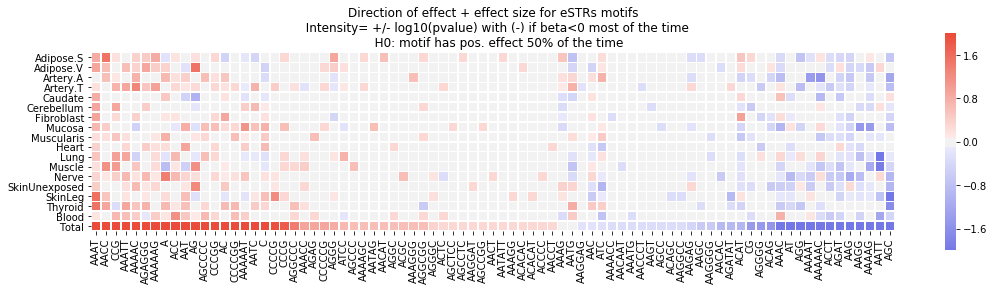

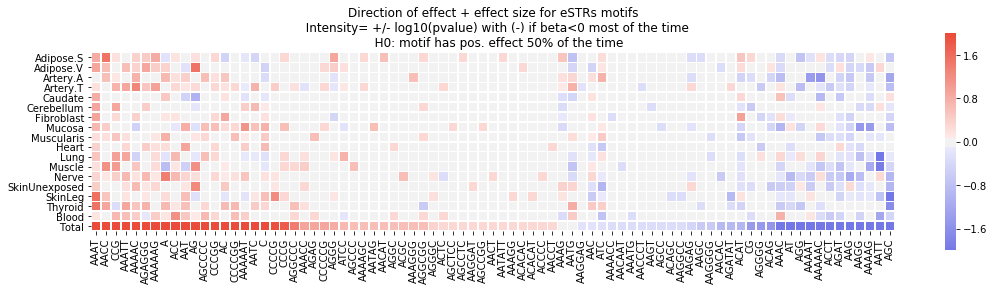

In [5]:
'''
metric="log binomial pval
'''
del sorted_df['Total']
#plot Enrichrment 
fig, ax = plt.subplots(figsize=(18, 20))
cmap = sns.diverging_palette(265, 15, s=80, l=55, n=9, as_cmap=True)    
sns.heatmap(sorted_df, cmap=cmap, 
            vmin=-2, vmax=2, square=True, ax=ax, linewidths=0.5, cbar_kws={"shrink": 0.2}
           ,yticklabels=[SHORTEN[t] for t in TISSUES]+['Total'], 
           xticklabels=list(sorted_df.columns)
           );
ax.invert_xaxis();
plt.title('Direction of effect + effect size for eSTRs motifs\n  Intensity= +/- log10(pvalue) with (-) if beta<0 most of the time\n   H0: motif has pos. effect 50% of the time')
fig.savefig(os.path.join(OUTPATH, "%s_Motif_direction_bias.pdf"%PREFIX))
plt.show()

In [6]:
#Counts only
Counts={}
Counts['Tissues']=TISSUES
ODDMOTIF=[]
for m in motifs:
    L=[]
    nul=0
    for T in TISSUES:
        GG = pd.read_csv(Cause+T+'/Master.table', sep='\t')
        EE =GG.loc[GG['qvalue']<=0.1]
        CC = [x for x in list(EE['top.variant']) if 'STR_' in x]
        E = EE.loc[EE['top.variant'].isin(CC)]
        Npos = E.loc[E['beta']>0]
        Nneg = E.loc[E['beta']<0]
        no = list(Npos['motif']).count(m)
        nn = list(Nneg['motif']).count(m)
        #Function to get effect size  ie effect of sample on motif (corr motif enrichment at eSTR vs any STR)
        pval = ss.binom_test(no, n=no+nn, p=0.5)   #[success is beta>0]
        if nn+no==0:
            Pv = 0
            nul = nul+1
        elif no/(no+nn) >0.5:
            Pv = +np.log10(pval)
        else:
            Pv = -np.log(pval)

        L.append(Pv)
    if nul==len(TISSUES):
        ODDMOTIF.append(m+'*')
    #elif nul!=len(TISSUES) and sum(L)==0:
    #    ODDMOTIF.append(m+'-')
    else:
        Counts[m]=L

print(len(ODDMOTIF),' motifs without counts\n', ODDMOTIF)
df = pd.DataFrame.from_dict(Counts)
df = df.sort_values('Tissues')
df.index = list(df['Tissues']) 
del df['Tissues']
df.loc['Total']= df.sum()
sorted_df = df.sort_values(df.last_valid_index(), axis=1)
#sorted_df



TypeError: argument of type 'float' is not iterable

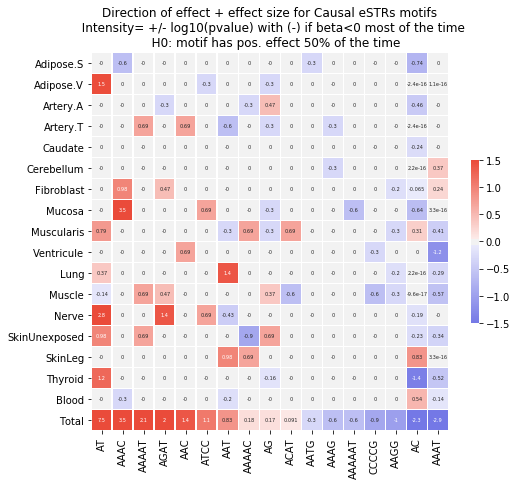

In [7]:
'''
metric="log binomial pval"
'''
#plot Enrichrment 
fig, ax = plt.subplots(figsize=(8, 15))
cmap = sns.diverging_palette(265, 15, s=80, l=55, n=9, as_cmap=True)    
sns.heatmap(sorted_df, cmap=cmap, annot_kws={"size":5},#annot=True,
            vmin=-1.5, vmax=1.5, square=True, ax=ax, linewidths=0.5, cbar_kws={"shrink": 0.2}
           ,yticklabels=[SHORTEN[t] for t in TISSUES]+['Total'], 
           xticklabels=list(sorted_df.columns)
           );
ax.invert_xaxis();
plt.title('Direction of effect + effect size for Causal eSTRs motifs\n  Intensity= +/- log10(pvalue) with (-) if beta<0 most of the time\n   H0: motif has pos. effect 50% of the time')
plt.show()